<a href="https://colab.research.google.com/github/rakshitsakhuja/AutoEncoder/blob/master/Gray_RGB_AutoEncoder_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Random Horizontal Flip
# pin memory
# num_workers
# imagenet model

In [1]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  59222      0 --:--:-- --:--:-- --:--:-- 59222
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
Uninstalling torch-1.5.1+cu101:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
| [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
/ [1 files][114.5 MiB/114.5 MiB]                                                
Operation completed over 1 objec

In [3]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp

# "Map function": acquires a corresponding Cloud TPU core, creates a tensor on it  and prints its core
def simple_map_fn(index, flags):
  # Sets a common random seed - both for initialization and ensuring graph is the same
  torch.manual_seed(42)

  # Acquires the (unique) Cloud TPU core corresponding to this process's index
  device = xm.xla_device()  

  # Creates a tensor on this process's device
  t = torch.randn((2, 2), device=device)

  print("Process", index ,"is using", xm.xla_real_devices([str(device)])[0])

  # Barrier to prevent master from exiting before workers connect.
  xm.rendezvous('init')

# Spawns eight of the map functions, one for each of the eight cores on
# the Cloud TPU
flags = {}
# Note: Colab only supports start_method='fork'
xmp.spawn(simple_map_fn, args=(flags,), nprocs=8, start_method='fork')

Process 0 is using TPU:0
Process 7 is using TPU:7
Process 5 is using TPU:5
Process 4 is using TPU:4
Process 1 is using TPU:1
Process 3 is using TPU:3
Process 6 is using TPU:6
Process 2 is using TPU:2


In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import cv2
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
np.set_printoptions(threshold=np.inf)

import os


# use_cuda=torch.cuda.is_available()
# use_cuda

In [21]:
import shutil
shutil.rmtree('/content/gdrive/My Drive/Dataset_Grey_RGB/images_1')

KeyboardInterrupt: ignored

In [6]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
import os 
# os.chdir(r"/content/gdrive/My Drive/Dataset_Grey_RGB/") 

In [ ]:
# # Download and unzip (2.2GB)
# !wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
# !tar -xzf testSetPlaces205_resize.tar.gz

In [22]:
len(os.listdir('images_1/val/class/'))

1000

In [23]:
len(os.listdir('images_1/train/class/'))

4999

In [ ]:
# import os
# os.makedirs('images/train/class/', exist_ok=True) # 40,000 images
# os.makedirs('images/val/class/', exist_ok=True)   #  1,000 images
# for i, file in enumerate(os.listdir('testSet_resize')):
#   if i < 1000: # first 1000 will be val
#     os.rename('testSet_resize/' + file, 'images/val/class/' + file)
#   elif i>1000 and i <6000: # others will be val
#     os.rename('testSet_resize/' + file, 'images/train/class/' + file)

In [24]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original).transpose((1,2,0))
      img_lab = rgb2lab(img_original)
      # print(img_lab.shape)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_grey = rgb2gray(img_original)
      img_grey = torch.from_numpy(img_grey).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_lab,img_original,img_grey,img_ab,target

In [25]:
def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  return color_image
  # plt.figure()
  # plt.imsave(arr = grayscale_input,fname ='grey.png')
  # plt.imsave(arr =color_image,fname ='colr11.png')

  
  # if save_path is not None and save_name is not None: 
  #   plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
  #   plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [26]:
def _make_grid(image_path_list,n_row=2, n_col=2,fig_size=(10,10)):
    # assert len(image_path_list) == n_row*n_col
    fig = plt.figure(figsize=fig_size)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(n_row,n_col),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    for i,(ax,fname )in enumerate(zip(grid, image_path_list)):
        # Iterating over the grid returns the Axes.
        # im= plt.imread(fname)
        # file_name = fname.split('/')[-1]
        if i in range(0,len(image_path_list),3):
          ax.imshow(fname,cmap='gray')
          ax.set_title('Grey Image',color='blue')
        elif i in range(2,len(image_path_list),3):
          ax.imshow(fname)
          ax.set_title('Original Image',color='blue')
        else:
          ax.imshow(fname)
          ax.set_title('Predicted Image',color='blue')

    plt.show()

## Definiing AutoEncoder-TransferLearning

In [51]:
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class AutoEncoder(nn.Module):
  def __init__(self, input_size=128):
    super(AutoEncoder, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(pretrained=True) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output
model = AutoEncoder()
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2875: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [42]:
def train(n_epochs,data_loader_train,data_loader_val,criterion,device):
  best_losses=1e10 
  model.train()  
  train_losses=[]
  val_losses=[]

  ## Trains
  train_start = time.time()
  for epoch in range(1, flags['num_epochs']+1):
 
      data_loss = 0.0
      total =0 

      time_start=time.time()
      para_train_loader = pl.ParallelLoader(data_loader_train, [device]).per_device_loader(device)
      for i,data in enumerate(para_train_loader):

          img_lab,img_original,img_grey,img_ab,target = data
          img_lab,img_original,img_grey,img_ab,target= img_lab.to(device),img_original.to(device),img_grey.to(device),img_ab.to(device),target.to(device)
        
          outputs = model(img_grey)
          loss = criterion(img_ab,outputs)

          optimizer.zero_grad()
          loss.backward()
          # optimizer.step()
          xm.optimizer_step(optimizer)

          data_loss += loss.item()
          total += 1         
         
          if i % 50 == 0:
            print('Epoch: {} \tIteration: {} Training Loss: {:.6f} \tTime Taken :{:.3f}'.format(
          epoch, 
          i,
          data_loss/total,
          time.time()-time_start
          ))
 

      data_loss = data_loss/total
      print('Process: {} \tEpoch: {} \tTraining Loss: {:.6f} \tTime Taken :{:.3f}'.format(
          index,
          epoch, 
          data_loss,
          time.time() - time_start
          ))
      train_losses.append(data_loss) 
      losses = validation(data_loader_val, model, criterion,epoch,device)
      val_losses.append(losses)
          # Save checkpoint and replace old best model if current model is better
      if losses < best_losses:
        best_losses = losses
        print('=====Saving Best Model========')
        torch.save(model.state_dict(), 'checkpoints/tpu_{}_resent_model-epoch-{}-losses-{:.3f}.pth'.format(index,epoch,losses)) 
  print("Process", index, "finished training. Train time was:", time.time() - time_start)    
  return train_losses,val_losses      
      



In [43]:
def validation(data_loader, model, criterion,epoch,device):  
  model.eval()
  time_start=time.time()
  with torch.no_grad():
    data_loss = 0.0
    total =0
    para_test_loader = pl.ParallelLoader(data_loader, [device]).per_device_loader(device)
    for i,data in enumerate(para_test_loader):
      time_start=time.time()
      img_lab,img_original,img_grey,img_ab,target = data
      img_lab,img_original,img_grey,img_ab,target= img_lab.to(device),img_original.to(device),img_grey.to(device),img_ab.to(device),target.to(device)

      outputs = model(img_grey)

      loss = criterion(img_ab,outputs)

      data_loss += loss.item()
      total += 1
      if i % 50 == 0:
        print('Epoch: {} \tIteration: {} Validation Loss: {:.6f} \t Time Taken :{:.3f}'.format(
            epoch, 
            i,
            data_loss/total,
            time.time() - time_start
            ))
  
        # exp_lr_scheduler.step()        
    data_loss = data_loss/total
    print('Epoch: {} \tValidation Loss: {:.6f} \tTime Taken :{:.3f}'.format(
            epoch, 
            data_loss,
            time.time() - time_start
            ))
  return data_loss

In [48]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch_xla.distributed.parallel_loader as pl
import time

def map_fn(index, flags):
  # Sets a common random seed - both for initialization and ensuring graph is the same
  torch.manual_seed(flags['seed'])

  # Acquires the (unique) Cloud TPU core corresponding to this process's index
  device = xm.xla_device()  


  image_size=224
  transform=transforms.Compose([
          transforms.Resize((image_size,image_size)),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor()
          # transforms.Normalize([0.485, 0.456, 0.406],
          #                      [0.229, 0.224, 0.225]
                              #  )  # Imagenet standards
      ])

  train_path=str('/content/gdrive/My Drive/Dataset_Grey_RGB/images_1/train')
  test_path=str('/content/gdrive/My Drive/Dataset_Grey_RGB/images_1/val')


  # normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
  #                                 std=[0.229, 0.224, 0.225])
  # to_rgb = transforms.Lambda(lambda image: image.convert('RGB'))
  # resize = transforms.Resize((224, 224))
  # my_transform = transforms.Compose([resize, to_rgb, transforms.ToTensor(), normalize])

  # # Downloads train and test datasets
  # # Note: master goes first and downloads the dataset only once (xm.rendezvous)
  # #   all the other workers wait for the master to be done downloading.

  # if not xm.is_master_ordinal():
  #   xm.rendezvous('download_only_once')

  train_dataset = GrayscaleImageFolder(root=train_path,transform=transform,)

  test_dataset = GrayscaleImageFolder(root=test_path,transform=transform)
  
  if xm.is_master_ordinal():
    xm.rendezvous('init')
    # xm.rendezvous('download_only_once')
  
  # Creates the (distributed) train sampler, which let this process only access
  # its portion of the training dataset.
  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  
  test_sampler = torch.utils.data.distributed.DistributedSampler(
    test_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=False)
  
  # Creates dataloaders, which load data in batches
  # Note: test loader is not shuffled or sampled
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=flags['batch_size'],
      sampler=train_sampler,
      pin_memory=True,
      num_workers=flags['num_workers'],
      drop_last=True)

  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=flags['batch_size'],
      sampler=test_sampler,
      pin_memory=True,
      num_workers=flags['num_workers'],
      drop_last=True)
  
  ## Network, optimizer, and loss function creation|

  # Creates Autoencoer for 10 classes
  # Note: each process has its own identical copy of the model
  #  Even though each model is created independently, they're also
  #  created in the same way.
  # net = torchvision.models.alexnet(num_classes=10).to(device).train()
  net = AutoEncoder().to(device)
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)


  train_losses,val_losses   = train(100,train_loader,test_loader,criterion,device)
  plt.plot(train_losses)
  plt.plot(val_losses)
  plt.show()

In [49]:
flags['batch_size'] = 16
flags['num_workers'] = 8
flags['num_epochs'] = 1
flags['seed'] = 1234

# ------------------------------------------------------
#   num_workers = 8
#   batch_size = 2
#   ----------------------------------------------------
xmp.spawn(map_fn, args=(flags,), nprocs=8, start_method='fork')

Exception in device=TPU:2: torch_xla/csrc/aten_xla_bridge.cpp:69 : Check failed: xtensor 
*** Begin stack trace ***
	tensorflow::CurrentStackTrace[abi:cxx11]()
	torch_xla::bridge::GetXlaTensor(at::Tensor const&)
	torch_xla::AtenXlaType::convolution_overrideable(at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long)
	c10::detail::wrap_kernel_functor_unboxed_<c10::detail::WrapRuntimeKernelFunctor_<at::Tensor (*)(at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long), at::Tensor, c10::guts::typelist::typelist<at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long> >, at::Tensor (at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool

Exception: ignored

In [8]:

def func_imshow(image, ax=None, title=None, normalize=True,gray=False):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,15))
    # image = image.numpy().transpose((1, 2, 0))
    image = image.numpy()
    # print(image.shape)

    if normalize is True:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        # print(std.shape)
        # print(mean.shape)
        # image = np.asarray(image).transpose((1,2,0))
        image = image*std + mean
        image = np.clip(image, 0, 1)
        # image = np.asarray(image).transpose((2,0,1))
    # else:
    #   image = np.asarray(image).transpose((1,2,0))

    if gray is True:
        ax.imshow(image,cmap='gray')
    else:
        ax.imshow(image)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


In [9]:
# from IPython.display import Image, display
# display(Image(filename='/content/gdrive/My Drive/Dataset_Grey_RGB/train_data/train/10459869.jpg'))

## Target Image

In [10]:
# img_ab.shape
# img_lab.shape
# img_original.shape
# img_grey.shape
# target.shape

In [11]:
# img_lab,img_original,img_grey,img_ab,target = next(iter(train_loader))
# plot = func_imshow(img_original[1], normalize=True)
# plot = func_imshow(img_lab[1], normalize=True)

In [12]:
# plot = func_imshow(img_original[1], normalize=False)
# plot = func_imshow(img_lab[1], normalize=False)

## Input Image

In [13]:
# plot = func_imshow(img_grey[1].squeeze(0), normalize=False,gray=True)

## Defining AutoEncoder -Scratch

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F

# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()
#         ## encoder layers ##
#         # self.conv1 = nn.Conv2d(1, 32 , 3, padding=1)  
#         # self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
#         # self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
#         # self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
#         # self.conv5 = nn.Conv2d(256, 128, 3, padding=1)
#         # self.conv6 = nn.Conv2d(128, 64, 3, padding=1)
#         # self.conv7 = nn.Conv2d(64, 32, 3, padding=1)
#         # self.conv_out = nn.Conv2d(32, 3, 3, padding=1)
#         self.conv1 = nn.Conv2d(1, 64 , 3, padding=1)  
#         # self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
#         self.conv5 = nn.Conv2d(256, 128, 3, padding=1)
#         self.conv6 = nn.Conv2d(128, 64, 3, padding=1)
#         self.conv_out = nn.Conv2d(64, 3, 3, padding=1)
#         # self.conv_out = nn.Conv2d(32, 3, 3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.sigmoid=nn.Sigmoid()
        


#     def forward(self, x):
#         ##  DECODER ##
#         # print(x.shape)
#         x = F.relu(self.conv1(x))
#         x = self.pool(x)
#         # print(x.shape)
#         # x = F.relu(self.conv2(x))
# #         x = self.pool(x)
#         # print(x.shape)
#         x = F.relu(self.conv3(x))
#         # print(x.shape)
        
#         x = F.relu(self.conv4(x))
#         # print(x.shape)
        
#         x = F.relu(self.conv5(x))                
# #         x = self.pool(x)
#         # print(x.shape)
#         x = F.interpolate(x, scale_factor=2, mode='nearest')
#         x = F.relu(self.conv6(x))
        
#         # print(x.shape)
        
#         # print(x.shape)
#         # x = F.relu(self.conv7(x))
#         # print(x.shape)
#         x = self.sigmoid(self.conv_out(x))
#         # print(x.shape)
                
#         return x

# # initialize the NN
# model = AutoEncoder()
# if use_cuda:
#     model.cuda()
# print(model)

In [ ]:

# MIDLEVEL_FEATURE_SIZE=512

# class AutoEncoder(nn.Module):
#     def __init__(self):
#       super(AutoEncoder, self).__init__()
#     ## encoder layers ##

#       vgg = models.vgg19(pretrained=True) 
#       list(vgg.children())[0][0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     # Change first conv layer to accept single-channel (grayscale) input
#       # vgg.features[0].weight = nn.Parameter(vgg.features[0].weight.sum(dim=1).unsqueeze(1)) 
#     # Extract midlevel features from VGG-gray
#       self.midlevel_vgg = nn.Sequential(*list(vgg.children())[0:1])
#       # for param in self.midlevel_vgg.parameters():
#       #   param.requires_grad = False

#     ## Second half: Upsampling
#       self.upsample = nn.Sequential(     
#         nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 256, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(256),
#         nn.ReLU(),
#         nn.Upsample(scale_factor=2),
#         nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(128),
#         nn.ReLU(),
#         nn.Upsample(scale_factor=2),
#         nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(64),
#         nn.ReLU(),
#         nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(64),
#         nn.ReLU(),
#         nn.Upsample(scale_factor=2),
#         nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(32),
#         nn.ReLU(),
#         nn.Upsample(scale_factor=2),
#         nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(16),
#         nn.ReLU(),
#         nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1),
#         nn.Upsample(scale_factor=2)
#       )

#     def forward(self, input):
#       # Pass input through ResNet-gray to extract features
#       midlevel_features = self.midlevel_vgg(input)
#       # print(midlevel_features.shape)

#         # Upsample to get colors
#       output = self.upsample(midlevel_features)
#       return output        
        
    

# initialize the NN
model = AutoEncoder()
# from unet import UNet
# model = UNet(in_channels=1, n_classes=2, padding=True,wf =5,depth=6, up_mode='upconv' )
if use_cuda:
    model.cuda()
# print(model)

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (3): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256,

In [ ]:
out = model(img_grey.cuda())
out.shape

torch.Size([2, 2, 224, 224])

In [ ]:
# specify loss function
criterion = nn.MSELoss()
if use_cuda:
  criterion = criterion.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001  , weight_decay=0.0)
# exp_lr_scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# number of epochs to train the model
n_epochs = 100

In [ ]:
# a=model(img_grey.cuda())
# a.shape

In [ ]:
import time 
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

In [ ]:
# def train(train_loader, model, criterion, optimizer, epoch):
#   print('Starting training epoch {}'.format(epoch))
#   model.train()
  
#   # Prepare value counters and timers
#   batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

#   end = time.time()
#   for i, (img_lab,img_original,input_gray,input_ab,target) in enumerate(train_loader):
    
#     # Use GPU if available
#     if use_cuda: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

#     # Record time to load data (above)
#     data_time.update(time.time() - end)

#     # Run forward pass
#     output_ab = model(input_gray) 
#     loss = criterion(output_ab, input_ab) 
#     losses.update(loss.item(), input_gray.size(0))

#     # Compute gradient and optimize
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # Record time to do forward and backward passes
#     batch_time.update(time.time() - end)
#     end = time.time()

#     # Print model accuracy -- in the code below, val refers to value, not validation
#     if i % 25 == 0:
#       print('Epoch: [{0}][{1}/{2}]\t'
#             'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
#             'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
#             'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
#               epoch, i, len(train_loader), batch_time=batch_time,
#              data_time=data_time, loss=losses)) 

#   print('Finished training epoch {}'.format(epoch))

In [ ]:
# for i in range(n_epochs):

#                         train(train_loader, model, criterion, optimizer, 3000)

In [ ]:
len(train_loader)
len(test_loader)

2500

500

In [ ]:
### Training Code total 50 times
aa =time.time()
time.time()-aa

5.6743621826171875e-05

In [ ]:
# os.listdir('/content/gdrive/My Drive/Dataset_Grey_RGB/checkpoints/')

In [ ]:
# model.load_state_dict
# model-epoch-17-losses-0.003.pth




model.load_state_dict(torch.load('/content/gdrive/My Drive/Dataset_Grey_RGB/checkpoints/resent_model-epoch-43-losses-0.003.pth'))
model.eval()


<All keys matched successfully>

AutoEncoder(
  (midlevel_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

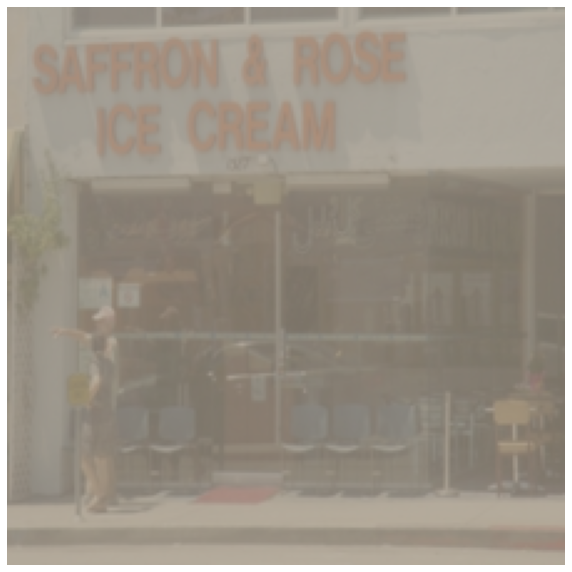

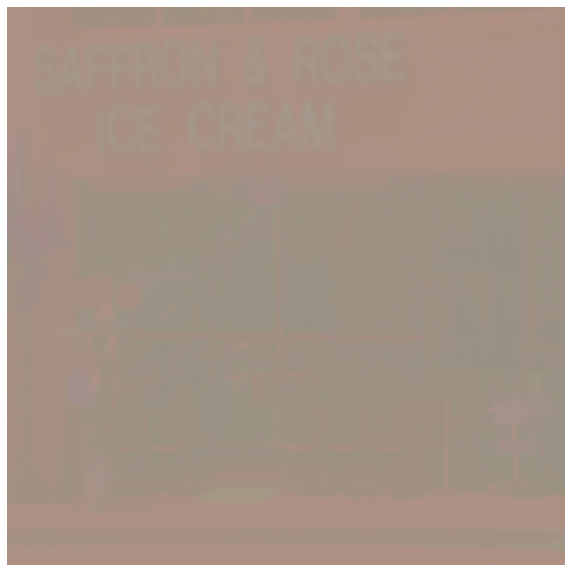

In [ ]:
img_lab,img_original,img_grey,img_ab,target = next(iter(train_loader))
plot = func_imshow(img_original[1], normalize=True)
plot = func_imshow(img_lab[1], normalize=True)

In [ ]:
img_lab,img_original,img_grey,img_ab,target = next(iter(test_loader))


In [ ]:
outputs = model(img_grey.cuda())

In [ ]:
outputs.shape

torch.Size([32, 2, 224, 224])

<Figure size 432x288 with 0 Axes>

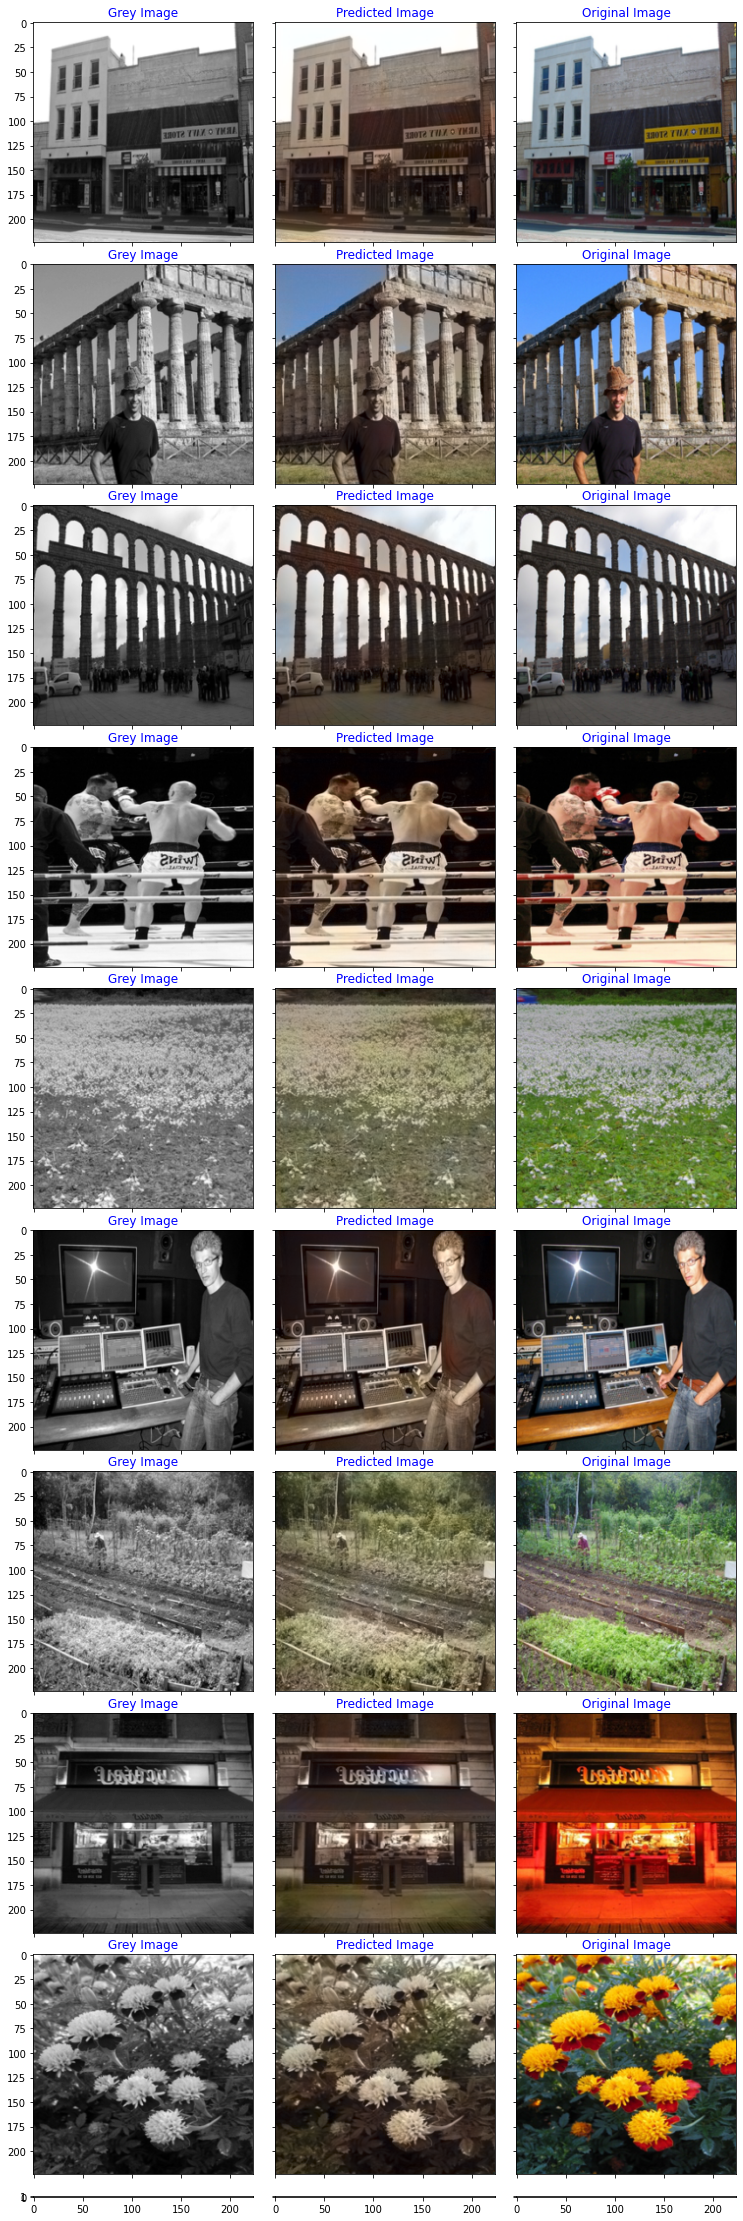

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
a=[]
for idx in np.unique(np.random.choice(range(0,32),10)):
  predicted_image = to_rgb(img_grey[idx].detach().cpu(),outputs[idx].detach().cpu() )
  a.extend(img_grey[idx].detach().cpu())
  a.extend([predicted_image])

  a.extend([img_original[idx]])

_make_grid(a,n_row=10, n_col=3,fig_size=(35,40))

In [ ]:
img_lab,img_original,img_grey,img_ab,target = next(iter(train_loader))
outputs = model(img_grey.cuda())

<Figure size 432x288 with 0 Axes>

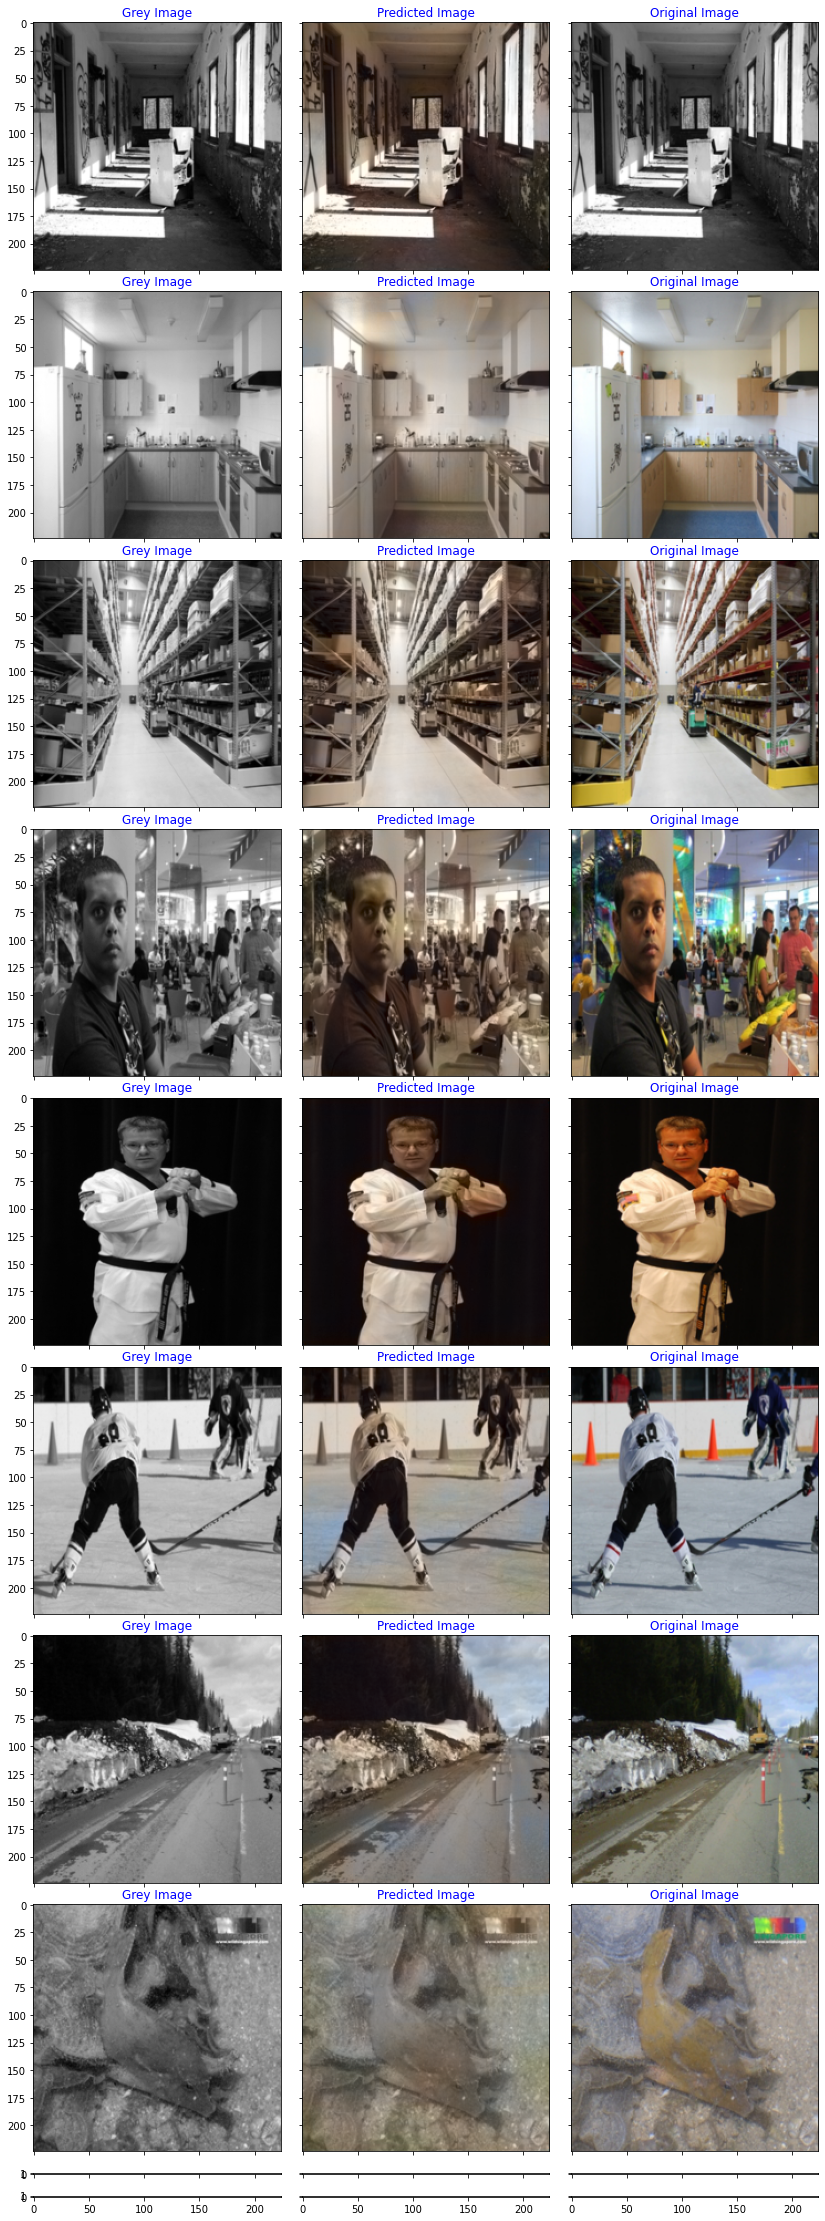

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
a=[]
for idx in np.unique(np.random.choice(range(0,32),10)):
  predicted_image = to_rgb(img_grey[idx].detach().cpu(),outputs[idx].detach().cpu() )
  a.extend(img_grey[idx].detach().cpu())
  a.extend([predicted_image])

  a.extend([img_original[idx]])

_make_grid(a,n_row=10, n_col=3,fig_size=(35,40))

In [ ]:
torch.save(model_training.state_dict(), '/content/gdrive/My Drive/Dataset_Grey_RGB/model_GREY_RGB_CSAIL_TRAINED_DATA_0249.state')

NameError: ignored

In [ ]:
n_epochs

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses,total = 0,0,0,0

  end = time.time()
  already_saved_images = False
  for i, (data) in enumerate(val_loader):
    img_lab,img_original,img_grey,img_ab,target=data

    data_time = (time.time() - end)

    # Use GPU
    if use_cuda:
      img_grey, img_ab, target = img_grey.cuda(), img_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(img_grey) # throw away class predictions
    loss = criterion(output_ab, img_ab)
    losses = (loss.item()*img_grey.size(0))
    total += img_grey.size(0)

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(img_grey[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time = (time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time:.3f} ({batch_time_avg:.3f})\t'
            'Loss {loss:.4f} ({loss_avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses,loss_avg = losses/total,batch_time_avg =batch_time/total))

  print('Finished validation.')
  return losses/total

In [ ]:
import time
validate(test_loader, model, criterion, True, n_epochs)

In [ ]:
# 
# model.load_state_dict(torch.load('/content/gdrive/My Drive/Dataset_Grey_RGB/model_GREY_RGB.state'))

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
img_lab,img_original,img_grey,img_ab,target = dataiter.next()
# gray_image = torch.tensor([cv2.cvtColor(i.cpu().numpy().transpose((1,2,0)), cv2.COLOR_RGB2GRAY) for i in images]).reshape(-1,1,image_size,image_size)
if use_cuda:
  gray_image=img_grey.cuda()
# get sample outputs
output = model(gray_image)
# prep images for display
gray_image_cpu = gray_image.cpu().numpy()


# output is resized into a batch of iages
# output = output.view(batch_size, 3, 224, 224)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()



In [ ]:
def to_rgb_batch(ab_output_batch, ab_output_batch, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image_batch = []
  for grayscale_input,ab_input in (ab_output_batch,ab_output_batch):
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    color_image_batch.append(color_image)
  return color_image_batch
  plt.figure()
  plt.imsave(arr = grayscale_input,fname ='grey.png')
  plt.imsave(arr =color_image,fname ='colr11.png')


SyntaxError: ignored

In [ ]:
to_rgb_batch(img_grey[idx].detach().cpu(),outputs[idx].detach().cpu().shape)

NameError: ignored

In [ ]:
cc = to_rgb(img_grey[idx].detach().cpu(),outputs[idx].detach().cpu() )
plt.imshow(cc)
plt.show()
plt.imshow(img_original[idx])
plt.show()

In [ ]:
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True,figsize=(15,15))

# input images on top row, reconstructions on bottom
for imagess, row in zip([images1, output], axes):
    for img, ax in zip(imagess, row):
        print(np.squeeze(img).shape)
        ax.imshow(np.squeeze(img.transpose((1,2,0))),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [ ]:
# gray_image =([cv2.cvtColor(i.transpose((1,2,0)), cv2.COLOR_RGB2GRAY) for i in images]).reshape(-1,1,image_size,image_size)
# gray_image.reshape(-1,1,image_size,image_size).shape

plot = func_imshow(images[1], normalize=False)

In [ ]:
# !ls ../input/model-r-g/

In [ ]:
# model1 = AutoEncoder()
# model1.load_state_dict(torch.load(open('../input/model-r-g/model_RGB_GREY.state','rb'), map_location='cpu'))